# Sklearn Pipeline and Transformers Deep Dive 
> A detailed tutorial on Sklearn Pipeline, ColumnTransformer, FunctionTransformer, and a custom transformer.

- toc: true 
- badges: true
- comments: true
- categories: [ml, sklearn]
- keywords: [sklearn, transformer, pipeline, ColumnTransformer, FunctionTransformer]
- image: images/copied_from_nb/images/2022-03-04-sklearn-pipeline-deep-dive.jpeg

![](images/2022-03-04-sklearn-pipeline-deep-dive.jpeg)

## About

This notebook shows various ways to work with Skearn Pipelines.
* We will start with some of the limitations of pipelines and how to overcome them
* We will discuss getting a dataframe from a pipeline instead of a NumPy array, and the benefits of this approach
* We will learn how to use CustomTransformer and a FunctionTrasformer
* We will also build a custom transformer to do some feature engineering
* Along the way, we will also see how to avoid common mistakes while creating pipelines

## Setup
### Environment Details

In [1]:
#collapse-hide
from platform import python_version
import sklearn, numpy, matplotlib, pandas

print("python==" + python_version())
print("sklearn==" + sklearn.__version__)
print("numpy==" + numpy.__version__)
print("pandas==" + pandas.__version__)
print("matplotlib==" + matplotlib.__version__)

python==3.8.8
sklearn==1.0.2
numpy==1.20.1
pandas==1.2.3
matplotlib==3.5.1


### Loading Data

For this example we will use the original `Titanic` dataset, describing the survival status of individual passengers on the Titanic ship.

Some notes from original source:
* The variables on our extracted dataset are 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare','cabin', 'embarked', 'boat', 'body', and 'home.dest'. 
* pclass refers to passenger class (1st, 2nd, 3rd), and is a proxy for socio-economic class. 
* Age is in years, and some infants had fractional values.
* sibsp = Number of Siblings/Spouses aboard
* parch = Number of Parents/Children aboard
* The target is either a person survived or not (1 or 0)

**Important note**: The purpose of this notebook is not to train a best model on titanic data, but to understand the working of Sklearn pipeline and transformers. So please be mindful of that.

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(42) # for consistency

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
##
# let's check the frequency of missing values in each feature
X.isnull().sum().sort_values(ascending=False)

body         1188
cabin        1014
boat          823
home.dest     564
age           263
embarked        2
fare            1
pclass          0
name            0
sex             0
sibsp           0
parch           0
ticket          0
dtype: int64

In [4]:
##
# let's drop top 4 features with highest percentage of missing data
# This step is done to make our working with pipeline simpler and easier to understand

X.drop(['body', 'cabin', 'boat', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
999,3.0,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0.0,0.0,383123,7.7500,Q
392,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1.0,0.0,SC/PARIS 2167,27.7208,C
628,3.0,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4.0,2.0,347082,31.2750,S
1165,3.0,"Saad, Mr. Khalil",male,25.0,0.0,0.0,2672,7.2250,C
604,3.0,"Abelseth, Miss. Karen Marie",female,16.0,0.0,0.0,348125,7.6500,S


## Some Terminology First

### [Datasets](https://scikit-learn.org/stable/tutorial/statistical_inference/settings.html#datasets)
Scikit-learn deals with learning information from one or more datasets that are represented as 2D arrays. They can be understood as a list of multi-dimensional observations. We say that the first axis of these arrays is the **samples axis**, while the second is the **features axis**.
> (n_samples, n_features)

In [5]:
##
# for our titanic dataset:
# n_samples = 1309
# n_features = 9
X.shape

(1309, 9)

### [Estimator](https://scikit-learn.org/stable/tutorial/statistical_inference/settings.html#estimators-objects)
An estimator is any object that learns from data; it may be a classification, regression or clustering algorithm or a transformer that extracts/filters useful features from raw data.

All estimator objects expose a fit method that takes a dataset (usually a 2-d array)
> estimator.fit(data)

### [Transformer](https://scikit-learn.org/stable/glossary.html#term-transformer)

An estimator supporting `transform` and/or `fit_transform` methods.

A transformer, transforms the input, usually only X, into some transformed space. Output is an array or sparse matrix of length n_samples and with the number of columns fixed after **fitting**.

### [Fit](https://scikit-learn.org/stable/glossary.html#term-fit)

The fit method is provided on every estimator. It usually takes some samples X, targets y if the model is supervised, and potentially other sample properties such as sample_weight. 

It should: 
* clear any prior attributes stored on the estimator, unless warm_start is used
* validate and interpret any parameters, ideally raising an error if invalid
* validate the input data
* estimate and store model attributes from the estimated parameters and provided data; and
* return the now fitted estimator to facilitate method chaining

Note: 
* **Fitting** = Calling `fit` (or `fit_transform`, `fit_predict`) method on an estimator.
* **Fitted** = The state of an estimator after fitting.

## [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
> class sklearn.pipeline.Pipeline(steps, *, memory=None, verbose=False)

It is a *pipeline of transformers with a final estimator*.

It sequentially applies a list of **transforms** and a final **estimator**. Intermediate steps of the pipeline must be **transforms**, that is, they must implement **fit** and **transform** methods. The final estimator only needs to implement **fit**.


Lets create a simple pipeline to better understand its componets. Steps in our pipeline will be
* replace missing values using the mean along each *numerical feature* column; and
* then scale them

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipe = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# our first pipeline has been initialized
pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

We can also visualize the pipeline as a diagram. It has two steps: imputer and scaler in sequence.

In [7]:
from sklearn import set_config
set_config(display="diagram")

pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

now lets call [**fit_transform**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.fit_transform) method to run this pipeline, and preprocess our loaded data

In [8]:
#collapse-output
pipe.fit_transform(X_train, y_train)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: "McCarthy, Miss. Catherine 'Katie'"

Aaargh! this is not what we intended. Let us try to understand why our pipeline did not work and then fix it. The exception message says: 
```
ValueError: Cannot use mean strategy with non-numeric data: could not convert string to float: "McCarthy, Miss. Catherine 'Katie'
```
From the error message we can deduce that Pipeline is trying to apply its transformers on all columns in the dataset. This was not our intention, as we wanted to apply the transformers to numeric data only. Let's limit our simple pipeline to numerical columns and run again.

In [9]:
num_cols = ['age', 'fare']
pipe.fit_transform(X_train[num_cols], y_train)

array([[ 0.        , -0.49963779],
       [-0.43641134, -0.09097855],
       [-1.44872891, -0.01824953],
       ...,
       [-0.98150542, -0.49349894],
       [-0.82576425, -0.44336498],
       [-0.59215251, -0.49349894]])

Alright, our pipeline has run now and we can also observe a few outcomes. 
* When we apply a pipeline to a dataset it will run transformers to all features in the dataset. 
* Output from one transformer will be passed on to the next one until we reach the end of the pipeline
* If we want to apply different transformers for numerical and categorical features (heterogeneous data) then the pipeline will not work for us. We would have to create separate pipelines for the different feature sets and then join the output.

To overcome the limitation of a pipeline for heterogeneous data, Sklearn recommends using `ColumnTransformer`. With ColumnTransformer we can provide column names against the transformers on which we want to apply them.

## [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

Let's see our first ColumnTransformer in action.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Note the sequence when creating a ColumnTransformer
# 1. a name for the transformer
# 2. the transformer
# 3. the column names

pipe = ColumnTransformer([
    ('standardscaler', StandardScaler(), ['age', 'fare'] ),
    ('onehotencoder', OneHotEncoder(), ['sex'])
    ])

pipe

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'fare']),
                                ('onehotencoder', OneHotEncoder(), ['sex'])])

In [11]:
##
# Let's execute our pipeline to see the output.
pipe.fit_transform(X_train, y_train)

array([[        nan, -0.49939913,  1.        ,  0.        ],
       [-0.39043136, -0.09093509,  1.        ,  0.        ],
       [-1.2960919 , -0.01824081,  1.        ,  0.        ],
       ...,
       [-0.87809473, -0.49326321,  0.        ,  1.        ],
       [-0.73876234, -0.4431532 ,  0.        ,  1.        ],
       [-0.52976375, -0.49326321,  0.        ,  1.        ]])

#### [get_feature_names_out(input_features=None)](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer.get_feature_names_out)

At this point I will also introduce a very useful function `get_feature_names_out(input_features=None)`.
Using this method we can get output feature names as well.

In [12]:
pipe.get_feature_names_out()

array(['standardscaler__age', 'standardscaler__fare',
       'onehotencoder__sex_female', 'onehotencoder__sex_male'],
      dtype=object)

Notice the output
* Output feature names appear as `<transformer_name>__<feature_name>`
* For OneHotEncoded feature "sex", output feature names have the label attached to them

#### [make_column_transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)

Sklean also provides a wrapper function for `ColumnTransformer` where we don't have to provide names for the transformers.

In [13]:
from sklearn.compose import make_column_transformer

# Note the sequence when using make_column_transformer
# 1. the transformer
# 2. the column names

pipe = make_column_transformer(
    (StandardScaler(), ['age', 'fare']),
    (OneHotEncoder(), ['sex'] ),
    verbose_feature_names_out=False # to keep output feature names simple
)

pipe

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'fare']),
                                ('onehotencoder', OneHotEncoder(), ['sex'])],
                  verbose_feature_names_out=False)

In [14]:
##
# Let's execute our pipeline.
pipe.fit_transform(X_train, y_train)

array([[        nan, -0.49939913,  1.        ,  0.        ],
       [-0.39043136, -0.09093509,  1.        ,  0.        ],
       [-1.2960919 , -0.01824081,  1.        ,  0.        ],
       ...,
       [-0.87809473, -0.49326321,  0.        ,  1.        ],
       [-0.73876234, -0.4431532 ,  0.        ,  1.        ],
       [-0.52976375, -0.49326321,  0.        ,  1.        ]])

In [15]:
##
# notice the feature names this time. they are shorter.
# we have used attribute "verbose_feature_names_out=False" in our pipeline above.
pipe.get_feature_names_out()

array(['age', 'fare', 'sex_female', 'sex_male'], dtype=object)

#### Important difference between Pipeline and ColumnTransformer
* Pipeline applies transformer in sequence on all columns
* ColumnTranformer applies transformers in parallel to specified columns and then concats the output

#### Open questions?

So our ColumnTransformer is working. But we have a few more questions to address.
* Why is the output from our pipeline or ColumnTransformer not shown as a dataframe with output features nicely separated in different columns?
* Our input dataset had more features besides age, fare, and sex. Why are they not present in the output?
* What happens if I change the sequence of transformers, and feature names in my ColumnTransformer?

In the coming sections, we will try to address these questions.

##### **Why is the output not a dataframe?**
The output from a pipeline or a ColumnTransformer is an nd-array where the first index is the number of samples, and second index are the output features `(n_samples, n_output_features)`. Since we are only getting numpy array as an output, we are losing information about the column names.

In [16]:
temp = pipe.fit_transform(X_train, y_train)

print(type(temp))
print(temp.shape)

<class 'numpy.ndarray'>
(1047, 4)


##### **Can we get the feature names back?**

We have already seen that we can get the output feature names using method `get_feature_names_out`. But this time let's try to analyze our ColumnsTransformer more closely. The transformer attributes discussed here also applies to Pipeline object.

In [17]:
##
# print the internals of ColumnTransformer

set_config(display='text')
pipe

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'fare']),
                                ('onehotencoder', OneHotEncoder(), ['sex'])],
                  verbose_feature_names_out=False)

ColumnTransformer has an attribute 'transformers' that is keeping a list of all the provided transformers. Let's print it.

In [18]:
pipe.transformers

[('standardscaler', StandardScaler(), ['age', 'fare']),
 ('onehotencoder', OneHotEncoder(), ['sex'])]

These are the transformers list at the initialization time. If we want to check the transformers after `fit` function has been called, then we need to print a different attribute `transformers_`.

In [19]:
pipe.transformers_

[('standardscaler', StandardScaler(), ['age', 'fare']),
 ('onehotencoder', OneHotEncoder(), ['sex']),
 ('remainder', 'drop', [0, 1, 4, 5, 6, 8])]

You can see the difference. There is an extra transformer with the name `remainder` at the end. It was not present at the initialization time. What it does is that it drops all remaining columns from the dataset that have not been explicitly used in the ColumnTransformer. Since, at the initialization time, ColumnTransformer does not know about the **other columns** that it needs to drop this transformer is missing. During fit it sees the dataset and knows about the other columns, it then keeps a list of them to drop **(0, 1, 4, 5, 6, 8)**.

We can also index through the transformers as well to fetch anyone from the list.

In [20]:
##
# second transformer from the list
pipe.transformers_[1]

('onehotencoder', OneHotEncoder(), ['sex'])

Notice the tuple sequence.
* First is the name
* Second is the **transformer**
* Third are the column names

We can also call `get_feature_names_out` method on a separate transformer from the list.

In [21]:
##
# output features from second tranformer
pipe.transformers_[1][1].get_feature_names_out()

array(['sex_female', 'sex_male'], dtype=object)

In [22]:
##
# output features from last tranformer
pipe.transformers_[-1][1].get_feature_names_out()

# No. We cannot do this on last transformer (remainder).

AttributeError: 'str' object has no attribute 'get_feature_names_out'

We now have output feature names, and the output (nd-array). Can we convert them to a DataFrame?

In [23]:
import pandas as pd

temp = pipe.fit_transform(X_train, y_train)
col_names = pipe.get_feature_names_out()

output = pd.DataFrame(temp.T, col_names).T
output.head()

,age,fare,sex_female,sex_male
0,NaN,-0.499399,1.0,0.0
1,-0.390431,-0.090935,1.0,0.0
2,-1.296092,-0.018241,1.0,0.0
3,-0.320765,-0.510137,0.0,1.0
4,-0.947761,-0.501444,1.0,0.0


## [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)

We know how to convert the transformer output to a DataFrame. It would be much simpler if we don't have to do an extra step, and can directly get a Dataframe from our fitted ColumnTransformer.

For this we can take the help of `FunctionTransformer`
> A FunctionTransformer forwards its X (and optionally y) arguments to a user-defined function or function object and returns the result of this function. 

Let's see a FunctionTransformer in action.

In [24]:
from sklearn.preprocessing import FunctionTransformer

preprocessor = make_column_transformer(
    (StandardScaler(), ['age', 'fare']),
    (OneHotEncoder(), ['sex'] ),
    verbose_feature_names_out=False
)

pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = preprocessor.get_feature_names_out())))
                    ])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fare']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(), ['sex'])],
                                   verbose_feature_names_out=False)),
                ('dataframer',
                 FunctionTransformer(func=<function <lambda> at 0x0000016196A1B040>))])

Notice that we have applied FunctionTransformer after ColumnTransformer in a Pipeline. When we fit our pipeline on the dataset, ColumnTransformer will be fitted first and then the FunctionTransformer. Since the ColumnTransformer has been fitted first, we will be able to call `get_feature_names_out` on it while passing data to FunctionTransformer.

In [25]:
##
# let's run our pipeline again
temp = pipe.fit_transform(X_train, y_train)
temp.head()

,age,fare,sex_female,sex_male
0,NaN,-0.499399,1.0,0.0
1,-0.390431,-0.090935,1.0,0.0
2,-1.296092,-0.018241,1.0,0.0
3,-0.320765,-0.510137,0.0,1.0
4,-0.947761,-0.501444,1.0,0.0


This is looking good. We are now getting back a dataframe directly from the pipeline. With a dataframe it is a lot easier to view and verify the output from the preprocessor.

But we have to be very careful with FunctionTransformer. In Sklearn docs, it says

**Note: If a lambda is used as the function, then the resulting transformer will not be pickleable.**

Huh! that is a very concerning point. We have also used a lambda function, and we will not be able to pickle it. Let's check it first.

In [26]:
import pickle

# save our pipeline
s1 = pickle.dumps(pipe)

# reload it
s2 = pickle.loads(s1)
s2

PicklingError: Can't pickle <function <lambda> at 0x0000016196A1B040>: attribute lookup <lambda> on __main__ failed

The documentation was right about it. We have used a Lambda function in our FunctionTranformer and we got a pickle error. Since, the limitation is said for Lambda function, changing it with a normal function should work. Let's do that.

In [27]:
def get_dataframe(X, transformer):
    """ 
    x: an nd-array
    transformer: fitted transformer
    """
    col_names = transformer.get_feature_names_out()
    output = pd.DataFrame(X.T, col_names).T
    return output

preprocessor = make_column_transformer(
    (StandardScaler(), ['age', 'fare']),
    (OneHotEncoder(), ['sex'] ),
    verbose_feature_names_out=False
)

dataframer = FunctionTransformer(func=get_dataframe, kw_args={"transformer": preprocessor})

pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer)
                ])

set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fare']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(), ['sex'])],
                                   verbose_feature_names_out=False)),
                ('dataframer',
                 FunctionTransformer(func=<function get_dataframe at 0x00000161953C3670>,
                                     kw_args={'transformer': ColumnTransformer(transformers=[('standardscaler',
                                                                                              StandardScaler(),
                                                                                              ['age',
                                                                                               'fare']),
                                                                                             ('onehotencoder',
                                                                                              OneHotEncoder(),
                                                                                              ['sex'])],
                                                                               verbose_feature_names_out=False)}))])

Notice the arguments for FunctionTransformer in the above code.
* first argument is the function to be called
* second argument are the parameters to be passed to our function

The sequence of arguments for the callable function will be
* first argument will be the output from any previous step in the pipeline (if there is any). In our case, it is nd-array coming from ColumnTransformer. It will be mapped to `X`. We don't have to do anything about it.
* second argument (if any) we want to pass to function. In our case we need it to be the fitted transformer from the previous step so we have explicitly passed it using `kw_args` as key-value pair. Where key name is the same as callable method argument name ('transformer' in our case). 

Now let's do our pickle test one more time.

In [28]:
##
# save our pipeline
s1 = pickle.dumps(pipe)

# reload it
s2 = pickle.loads(s1)
s2

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'fare']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(), ['sex'])],
                                   verbose_feature_names_out=False)),
                ('dataframer',
                 FunctionTransformer(func=<function get_dataframe at 0x00000161953C3670>,
                                     kw_args={'transformer': ColumnTransformer(transformers=[('standardscaler',
                                                                                              StandardScaler(),
                                                                                              ['age',
                                                                                               'fare']),
                                                                                             ('onehotencoder',
                                                                                              OneHotEncoder(),
                                                                                              ['sex'])],
                                                                               verbose_feature_names_out=False)}))])

Alright, no more issues so let's proceed to our next question.

### Where are the rest of the columns?
By default, only the specified columns in transformers are transformed and combined in the output, and the non-specified columns are dropped. (default of `remainder='drop'`). By specifying `remainder='passthrough'`, all remaining columns that were not specified in transformers will be automatically passed through. This subset of columns is concatenated with the output of the transformers.

Let's see it in action.

In [29]:
preprocessor = make_column_transformer(
    (StandardScaler(), ['age', 'fare']),
    (OneHotEncoder(), ['sex'] ),
    verbose_feature_names_out=False,
    remainder='passthrough'
)

# get_dataframe is already defined in last section. Intentionally omitted here. 
dataframer = FunctionTransformer(func=get_dataframe, kw_args={"transformer": preprocessor})

pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer)
                ])

temp = pipe.fit_transform(X_train, y_train)
temp.head()

,age,fare,sex_female,sex_male,pclass,name,sibsp,parch,ticket,embarked
0,NaN,-0.499399,1.0,0.0,3.0,"McCarthy, Miss. Catherine 'Katie'",0.0,0.0,383123,Q
1,-0.390431,-0.090935,1.0,0.0,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",1.0,0.0,SC/PARIS 2167,C
2,-1.296092,-0.018241,1.0,0.0,3.0,"Andersson, Miss. Sigrid Elisabeth",4.0,2.0,347082,S
3,-0.320765,-0.510137,0.0,1.0,3.0,"Saad, Mr. Khalil",0.0,0.0,2672,C
4,-0.947761,-0.501444,1.0,0.0,3.0,"Abelseth, Miss. Karen Marie",0.0,0.0,348125,S


We have our remaining features back now, so let's proceed to our next question.

### What happens if I change the sequence in ColumnTranformer?
It is better to make some changes and then see the results. I am making two changes in ColumnTransformer
1. Changed the order of transformers (OHE before scaling)
2. Changed the order of features inside the transformer ('fare' before 'age')

In [30]:
preprocessor = make_column_transformer(
    (OneHotEncoder(), ['sex'] ),
    (StandardScaler(), ['fare', 'age']),
    verbose_feature_names_out=False,
    remainder='passthrough'
)

# get_dataframe is already defined in last section. Intentionally omitted here. 
dataframer = FunctionTransformer(func=get_dataframe, kw_args={"transformer": preprocessor})

pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer)
                ])

temp = pipe.fit_transform(X_train, y_train)
temp.head()

,sex_female,sex_male,fare,age,pclass,name,sibsp,parch,ticket,embarked
0,1.0,0.0,-0.499399,NaN,3.0,"McCarthy, Miss. Catherine 'Katie'",0.0,0.0,383123,Q
1,1.0,0.0,-0.090935,-0.390431,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",1.0,0.0,SC/PARIS 2167,C
2,1.0,0.0,-0.018241,-1.296092,3.0,"Andersson, Miss. Sigrid Elisabeth",4.0,2.0,347082,S
3,0.0,1.0,-0.510137,-0.320765,3.0,"Saad, Mr. Khalil",0.0,0.0,2672,C
4,1.0,0.0,-0.501444,-0.947761,3.0,"Abelseth, Miss. Karen Marie",0.0,0.0,348125,S


We can see that changing the sequence in ColumnTransformer does change the output. Also note
* Specified columns in transformers are transformed and combined in the output
* Transformers sequence in ColumnTransformer also represents the columns sequence in the output
* When `remainder=passthrough` is used then remaining columns will be appended at the end. Remainder columns sequence will be same as in the input.

## Pipeline inside ColumnTransformer
Let's assume we have more requirements this time. I want
* for numerical features (age, fare): impute the missing values first, and then scale them
* for categorical features (sex): one hot encode them

Our pipeline will look like this.

In [31]:
#collapse-output
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
        ])

categorical_features = ["sex"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features), # note "numeric_transformer" is a pipeline this time
        (categorical_transformer, categorical_features),
        remainder='passthrough',
        verbose_feature_names_out=False
)

dataframer = FunctionTransformer(func=get_dataframe, kw_args={"transformer": preprocessor})
pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer)
                ])

temp = pipe.fit_transform(X_train, y_train)
temp.head()

AttributeError: Estimator imputer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

Oh geez! What went wrong this time. The error message says
```
AttributeError: Estimator imputer does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?
```
From the error message I am getting that
> Estimator imputer does not provide get_feature_names_out

Hmmm, this is strange. Why is this estimator missing a very useful function? Let's check the docs first on [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). For the docs I indeed could not find this method `get_feature_names_out()` for this transformer. A little googling lead me to this Sklearn Github issue page [Implement get_feature_names_out for all estimators](https://github.com/scikit-learn/scikit-learn/issues/21308). Developers are actively adding `get_feature_names_out()` to all estimators and transformers, and it looks like this feature has not been implemented for `SimpleImputer` till Sklearn version==1.0.2. 

But no worries we can overcome this limitation, and implement this feature ourselves through a custom transformer. 

## [Custom Transformer](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator)

We can create a custom transformer or an estimator simply by inheriting a class from `BaseEstimator` and optionally the mixin classes in `sklearn.base`. Sklean provides a template that we can use to create our custom transformer. Template link is here: https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py#L146

Let us use the same pipeline as in last cell but replace `SimpleImputer` with a custom one.

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class SimpleImputerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
       
        
    def fit(self, X, y):
        self.imputer.fit(X, y)
        return self
    
    def transform(self, X):
        return self.imputer.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # we have returned the input features name as out features will have the same name
        return input_features


numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[
            ("imputer", SimpleImputerCustom(strategy='mean')),
            ("scaler", StandardScaler())
             ]
)


categorical_features = ["sex"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features), # note "numeric_transformer" is a pipeline
        (categorical_transformer, categorical_features),
        remainder='passthrough',
    verbose_feature_names_out=False
)

dataframer = FunctionTransformer(func=get_dataframe, kw_args={"transformer": preprocessor})
pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer)
                ])

temp = pipe.fit_transform(X_train, y_train)
temp.head()

,age,fare,sex_female,sex_male,pclass,name,sibsp,parch,ticket,embarked
0,0.0,-0.499638,1.0,0.0,3.0,"McCarthy, Miss. Catherine 'Katie'",0.0,0.0,383123,Q
1,-0.436411,-0.090979,1.0,0.0,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",1.0,0.0,SC/PARIS 2167,C
2,-1.448729,-0.01825,1.0,0.0,3.0,"Andersson, Miss. Sigrid Elisabeth",4.0,2.0,347082,S
3,-0.358541,-0.510381,0.0,1.0,3.0,"Saad, Mr. Khalil",0.0,0.0,2672,C
4,-1.059376,-0.501684,1.0,0.0,3.0,"Abelseth, Miss. Karen Marie",0.0,0.0,348125,S


## Feature Engineering with Custom Transformer

So far, so good! Let's assume that we have another requirement and it is about feature engineering. We have to combine 'sibsp' and 'parch' into two new features: family_size and is_alone.

Let's implement this now.

In [33]:
class FamilyFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
       
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X['family_size'] = X['parch'] + X['sibsp']
        X.drop(['parch', 'sibsp'], axis=1, inplace=True) # we can drop this feature now
        X['is_alone'] = 1
        X.loc[X['family_size'] > 1, 'is_alone'] = 0
        return X
    
    def get_feature_names_out(self, input_features=None):
        # this time we have created new features. Their names are different from input features.
        # so we have explicitly mentioned them here.
        return ['family_size', 'is_alone']

numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[
            ("imputer", SimpleImputerCustom(strategy='mean')),
            ("scaler", StandardScaler())
             ]
)

categorical_features = ["sex"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

family_features = ["parch", "sibsp"]
family_transformer = FamilyFeatureTransformer()

preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features), 
        (categorical_transformer, categorical_features),
        (family_transformer, family_features),
        remainder='drop', # let's drop extra features this time
    verbose_feature_names_out=False
)

dataframer = FunctionTransformer(func=get_dataframe, kw_args={"transformer": preprocessor})
pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer)
                ])

temp = pipe.fit_transform(X_train, y_train)
temp.head()

,age,fare,sex_female,sex_male,family_size,is_alone
0,0.000000,-0.499638,1.0,0.0,0.0,1.0
1,-0.436411,-0.090979,1.0,0.0,1.0,1.0
2,-1.448729,-0.018250,1.0,0.0,6.0,0.0
3,-0.358541,-0.510381,0.0,1.0,0.0,1.0
4,-1.059376,-0.501684,1.0,0.0,0.0,1.0


## Sklean Pipeline with Feature Importance

Alright, we have our required features ready and we can now pass them to a classifier. Let's use RandomForrest as our classifier and run our pipeline with it.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 'preprocessor' and 'dataframer' are already declared in last section, and intentionally omitted here.
pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer),
                    ('rf_estimator', RandomForestClassifier())

                ])

temp = pipe.fit_transform(X_train, y_train)
temp.head()

AttributeError: 'RandomForestClassifier' object has no attribute 'transform'

Okay, looks like we have made a mistake here. Error message is saying
```
AttributeError: 'RandomForestClassifier' object has no attribute 'transform'
```
I get that. In our pipeline we have an estimator that does not have a `transform` method defined for it. We should use `predict` method instead.

Note:
* Estimators implement predict method ([Template reference Estimator](https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py#L11), [Template reference Classifier](https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py#L74))
* Transformers implement transform method ([Template reference Transformer](https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py#L146))
* `fit_transform` is same calling `fit` and then `transform`

Let us fix the error and run our pipeline again.

In [35]:
##
# pipeline created in last section and intentionally omitted here.
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.7862595419847328

Let's see how our final pipeline looks visually.

In [36]:
##
# set_config(display='text')
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputerCustom()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('familyfeaturetransformer',
                                                  FamilyFeatureTransformer(),
                                                  ['parch', 'sibsp'])],
                                   verbose_feature_names_out=False)),
                ('data...
                                     kw_args={'transformer': ColumnTransformer(transformers=[('pipeline',
                                                                                              Pipeline(steps=[('imputer',
                                                                                                               SimpleImputerCustom()),
                                                                                                              ('scaler',
                                                                                                               StandardScaler())]),
                                                                                              ['age',
                                                                                               'fare']),
                                                                                             ('onehotencoder',
                                                                                              OneHotEncoder(handle_unknown='ignore'),
                                                                                              ['sex']),
                                                                                             ('familyfeaturetransformer',
                                                                                              FamilyFeatureTransformer(),
                                                                                              ['parch',
                                                                                               'sibsp'])],
                                                                               verbose_feature_names_out=False)})),
                ('rf_estimator', RandomForestClassifier())])

We can also get the importance of features in our dataset from RandomForrest classifier.

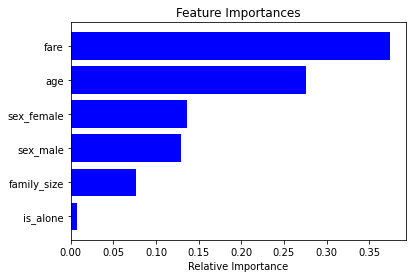

In [37]:
import matplotlib.pyplot as plt

clf = pipe[-1] # last estimator is the RF classifier
importances = clf.feature_importances_
features = clf.feature_names_in_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Note that all the feature names were passed to the RF Classifier and that is why we were able to get them back using its attribute `feature_names_in_`. This can be super useful when you have many model deployed in the environment, and you can just use the model object to get information about the features it was trained on.

For a moment let's also remove the feature names from our pipeline and see how it will effect our feature importance plot.

In [38]:
pipe = Pipeline([
                    ("preprocess", preprocessor),
                    # ("dataframer", dataframer),
                    ('rf_estimator', RandomForestClassifier())

                ])

# fit the pipeline
pipe.fit(X_train, y_train)

# get the feature importance plot
clf = pipe[-1]
importances = clf.feature_importances_
features = clf.feature_names_in_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AttributeError: 'RandomForestClassifier' object has no attribute 'feature_names_in_'

No feature names were passed to our classifier this time and it is missing `feature_names_in_` attribute. We can circumvent this and still get feature importance plot.

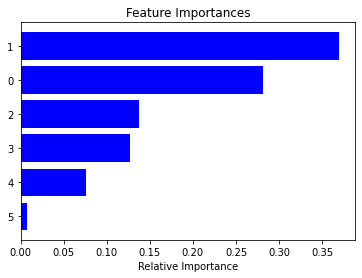

In [39]:
pipe = Pipeline([
                    ("preprocess", preprocessor),
                    # ("dataframer", dataframer),
                    ('rf_estimator', RandomForestClassifier())

                ])

# fit the pipeline
pipe.fit(X_train, y_train)

# get the feature importance plot
clf = pipe[-1]
importances = clf.feature_importances_
# features = clf.feature_names_in_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [i for i in indices])
plt.xlabel('Relative Importance')
plt.show()

This time we get the same plot but not withOUT feature names, and it is not useful anymore. So definitely we need to keep the feature names with the final estimator. Feature names can help us a lot in interpreting the model.

## The complete Pipeline

For an easy reference, let's put the whole pipeline in one place.
### Load Data

In [40]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

np.random.seed(42) # for consistency

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

X.drop(['body', 'cabin', 'boat', 'home.dest'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
999,3.0,"McCarthy, Miss. Catherine 'Katie'",female,NaN,0.0,0.0,383123,7.7500,Q
392,2.0,"del Carlo, Mrs. Sebastiano (Argenia Genovesi)",female,24.0,1.0,0.0,SC/PARIS 2167,27.7208,C
628,3.0,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4.0,2.0,347082,31.2750,S
1165,3.0,"Saad, Mr. Khalil",male,25.0,0.0,0.0,2672,7.2250,C
604,3.0,"Abelseth, Miss. Karen Marie",female,16.0,0.0,0.0,348125,7.6500,S


### Train Model

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

class FamilyFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
       
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X['family_size'] = X['parch'] + X['sibsp']
        X.drop(['parch', 'sibsp'], axis=1, inplace=True) # we can drop this feature now
        X['is_alone'] = 1
        X.loc[X['family_size'] > 1, 'is_alone'] = 0
        return X
    
    def get_feature_names_out(self, input_features=None):
        # this time we have created new features. Their names are different from input features.
        # so we have explicitly mentioned them here.
        return ['family_size', 'is_alone']

class SimpleImputerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
       
        
    def fit(self, X, y):
        self.imputer.fit(X, y)
        return self
    
    def transform(self, X):
        return self.imputer.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # we have returned the input features name as out features will have the same name
        return input_features

def get_dataframe(X, transformer):
    """ 
    x: an nd-array
    transformer: fitted transformer
    """
    col_names = transformer.get_feature_names_out()
    output = pd.DataFrame(X.T, col_names).T
    return output
    
numeric_features = ["age", "fare"]
numeric_transformer = Pipeline(
    steps=[
            ("imputer", SimpleImputerCustom(strategy='mean')),
            ("scaler", StandardScaler())
             ]
)

categorical_features = ["sex"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

family_features = ["parch", "sibsp"]
family_transformer = FamilyFeatureTransformer()

preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features), 
        (categorical_transformer, categorical_features),
        (family_transformer, family_features),
        remainder='drop', # let's drop extra features this time
    verbose_feature_names_out=False
)

dataframer = FunctionTransformer(func=get_dataframe, kw_args={"transformer": preprocessor})
pipe = Pipeline([
                    ("preprocess", preprocessor),
                    ("dataframer", dataframer),
                    ('rf_estimator', RandomForestClassifier())

                ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.8015267175572519

### Plot Feature Importance

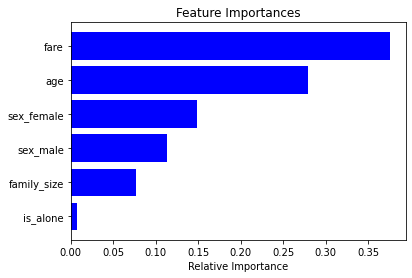

In [42]:
import matplotlib.pyplot as plt

clf = pipe[-1] # last estimator is the RF classifier
importances = clf.feature_importances_
features = clf.feature_names_in_

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Pickle Test

In [43]:
from sklearn import set_config
set_config(display="diagram")

import pickle

# save our pipeline
s1 = pickle.dumps(pipe)

# reload it
s2 = pickle.loads(s1)
s2

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputerCustom()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('familyfeaturetransformer',
                                                  FamilyFeatureTransformer(),
                                                  ['parch', 'sibsp'])],
                                   verbose_feature_names_out=False)),
                ('data...
                                     kw_args={'transformer': ColumnTransformer(transformers=[('pipeline',
                                                                                              Pipeline(steps=[('imputer',
                                                                                                               SimpleImputerCustom()),
                                                                                                              ('scaler',
                                                                                                               StandardScaler())]),
                                                                                              ['age',
                                                                                               'fare']),
                                                                                             ('onehotencoder',
                                                                                              OneHotEncoder(handle_unknown='ignore'),
                                                                                              ['sex']),
                                                                                             ('familyfeaturetransformer',
                                                                                              FamilyFeatureTransformer(),
                                                                                              ['parch',
                                                                                               'sibsp'])],
                                                                               verbose_feature_names_out=False)})),
                ('rf_estimator', RandomForestClassifier())])